# Logistic Regression Backtesting

In [ ]:
# All the import statements we need for preprocessing the data 
import pandas as pd
import numpy as np
from backtesting import Backtest, Strategy
import yfinance as yf
from sklearn.preprocessing import StandardScaler

# Setting a random seed
np.random.seed(42)

# Cleaning and reading the csv file 
df = pd.read_csv("../Data/^GSPC.csv")
df = df[df["Price"] != "Ticker"]
df = df[df["Price"] != "Date"]
df[['Close','High', 'Low', 'Open', 'Volume']] = df[['Close', 'High', 'Low', 'Open', 'Volume']].astype(float)
df['Price'] = pd.to_datetime(df['Price'])
df.set_index('Price', inplace=True)
df.index.name = None

# This function adds technical indicators and features to the data 
def add_features(data):
    df = data.copy()

    # These are the technical indicators that we will use from the yfinance library
    df['MA5'] = df['Close'].rolling(window=5).mean()
    df['MA10'] = df['Close'].rolling(window=10).mean()
    df['MA20'] = df['Close'].rolling(window=20).mean()
    df['Volatility'] = df['Close'].pct_change().rolling(window=10).std()
    df['Momentum'] = df['Close'] - df['Close'].shift(5)
    df['Return'] = df['Close'].pct_change()

    # These are features that we engineered from the technical indicators that we will use for our model. We added the 
    # X_ prefix to the features to indicate that they are engineered features
    df['X_MA5'] = (df['Close'] - df['MA5']) / df['Close']
    df['X_MA10'] = (df['Close'] - df['MA10']) / df['Close']
    df['X_MA20'] = (df['Close'] - df['MA20']) / df['Close']
    df['X_MA5_10'] = (df['MA5'] - df['MA10']) / df['Close']
    df['X_MA10_20'] = (df['MA10'] - df['MA20']) / df['Close']
    df['X_Volatility'] = df['Volatility']
    df['X_Momentum'] = df['Momentum']
    df['X_Return'] = df['Return']
    df['X_Return_5'] = df['Return'].rolling(5).sum()
    df['X_VOL_CHG'] = df['Volume'].pct_change(5)
    # The 'Target' column is a ternary classification problem with labels -1, 0, and 1 indicating down, neutral, and up movements
    df['Target'] = np.where(df['Return'].shift(-1) > 0.005, 1,
                    np.where(df['Return'].shift(-1) < -0.005, -1, 0))

    return df  

# The get_X and get_y functions are helper functions that extract features and labels from the data
def get_X(data):
    feature_columns = [col for col in data.columns if col.startswith('X_')]
    return data[feature_columns].values

def get_y(data):
    return data.Target.values

# We apply the features to the dataframe 
df = add_features(df)


In [ ]:
from sklearn.linear_model import LogisticRegression


class strategy_class(Strategy):
# this is the function that we will use to initialize the machine learning model we will as well as the features that we will use in our model
    def init(self):
        self.model = LogisticRegression(max_iter=1000, random_state=42) # This is initalizing the parameters in the LogisticRegression model 
        self.features = [col for col in self.data.df.columns if col.startswith("X_")] # This is adding the features with the X_ prefix to the model
        self.df = add_features(self.data.df).fillna(method='ffill').fillna(method='bfill') # This adds missing features using forward and backward fill
        self.pred = self.I(lambda: np.zeros(len(self.df)), name='pred') 
        self.predictions = [] 
        self.actuals = []

# The def next(self) function is the function that runs the strategy that we've created 
    def next(self):
        i = len(self.data)

        # We want to check if i >= 200 because that ensures that we have enough data points to train the model
        if i < 200:
            return
        
        # Splitting the data into training and testing sets
        train = self.df.iloc[i-200:i]
        test = self.df.iloc[[i-1]]
        X_train = train[self.features].values
        y_train = train["Target"].values
        X_test = test[self.features].values
        y_true = test["Target"].values[0]
        self.model.fit(X_train, y_train) # Fitting the model to the training data
        pred = self.model.predict(X_test)[0] # Making a prediction on the test data
        self.pred[-1] = pred

        # This is the part of the code that we will use to help evaluate the model. Where we append 
        # the predictions and actual values to the lists. 
        if pred in [-1, 0, 1]:
            self.predictions.append(pred)
            self.actuals.append(int(y_true))

        # This part of the code is used to either buy or sell the stock based on the predictions made by the model. 
        # If the prediction is 1, we buy the stock. If the prediction is -1, we sell the stock. Finally, if the prediction is 0, we do nothing.
        if pred == 1:
            if not self.position.is_long:
                self.position.close()
                self.buy()
        elif pred == -1:
            if not self.position.is_short:
                self.position.close()
                self.sell()


In [ ]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# This function is used to evaluate the model on accuracy, precision, and f1 score.
# In addition to the metrics we find, it also plots the confusion matrix 

def evaluate_strategy(y_true, y_pred):

    print("Evaluation Metrics")
    print("Accuracy:", round(accuracy_score(y_true, y_pred), 4))
    print("Precision (macro):", round(precision_score(y_true, y_pred, average='macro'), 4))
    print("F1 Score (macro):", round(f1_score(y_true, y_pred, average='macro'), 4))

    cm = confusion_matrix(y_true, y_pred, labels=[-1, 0, 1])
    disp = ConfusionMatrixDisplay(cm, display_labels=['Down (-1)', 'Neutral (0)', 'Up (1)'])
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

In [ ]:
# Running the model on backtest
bt = Backtest(df, strategy_class, cash=10_000, commission=.0002)
backtest = bt.run()
backtest

/var/folders/qj/c7654q5s2zb76938lp4d13y80000gn/T/ipykernel_14538/2727551733.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.df = add_features(self.data.df).fillna(method='ffill').fillna(method='bfill')


Backtest.run:   0%|          | 0/986 [00:00<?, ?it/s]

Start                     2020-01-30 00:00:00
End                       2023-12-29 00:00:00
Duration                   1429 days 00:00:00
Exposure Time [%]                    77.91287
Equity Final [$]                   12052.4503
Equity Peak [$]                   13276.50834
Commissions [$]                     240.38093
Return [%]                            20.5245
Buy & Hold Return [%]                45.25956
Return (Ann.) [%]                     4.88179
Volatility (Ann.) [%]                 12.8202
CAGR [%]                              3.34689
Sharpe Ratio                          0.38079
Sortino Ratio                         0.55815
Calmar Ratio                          0.24969
Alpha [%]                            19.05521
Beta                                  0.03246
Max. Drawdown [%]                   -19.55166
Avg. Drawdown [%]                     -1.6605
Max. Drawdown Duration      443 days 00:00:00
Avg. Drawdown Duration       22 days 00:00:00
# Trades                          

In [ ]:
# This plots the results of the backtest
bt.plot()

GridPlot(id='p1377', ...)

Evaluation Metrics
Accuracy: 0.4518
Precision (macro): 0.4262
F1 Score (macro): 0.426


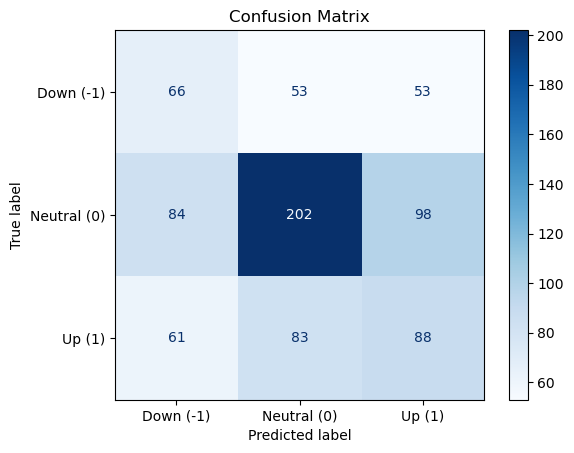

In [ ]:
# This evaluates the model on prediction and actual values
predictions = backtest._strategy.predictions
actuals = backtest._strategy.actuals
evaluate_strategy(predictions, actuals)